# Laboratorio 7 - Simulación del Sistema de Torniquetes con SimPy

#### Ignacio Chaparro - 202220577
#### Mateo Lopez - 202220119

## Problema

La Universidad de los Andes ha mantenido un número constante de estudiantes durante los últimos 7 años. Sin embargo, debido a la adición de nuevos edificios y diversas tendencias en el país, la Dirección de Planeación de la universidad estima que para el año 2025 la población estudiantil crecerá en un 28 %. Esto ha generado preocupación entre algunos miembros sobre si nuestra infraestructura actual puede manejar tal incremento de estudiantes. En particular, hay inquietudes respecto al sistema de torniquetes. Para abordar estas inquietudes, la administración decidió acercarse a los estudiantes de ingeniería de sistemas que están cursando MOS. Se les proporcionó acceso a un conjunto de datos de un semestre pasado que contiene todas las entradas y salidas del edificio Santo Domingo (SD), con el propósito de realizar una prueba de concepto sobre cómo se podría implementar la simulación de un solo edificio antes de simular toda la universidad.

En el caso del edificio SD, se cuenta con 6 torniquetes ajustados a una única dirección (3 para entrar y 3 para salir). Los datos muestran el flujo semanal (de lunes a sábado) de estudiantes, profesores y personal administrativo que entran y salen del edificio. El objetivo de este estudio es diseñar con gran fidelidad y detalle el comportamiento de la entrada y salida de personas en este edificio.

Para ello, se consideran las siguientes especificaciones: el tiempo para pasar por un torniquete es de 5 segundos, el tiempo necesario para tener el carnet en mano y estar listo para entrar es de unos 10 segundos, y el tiempo de lectura de QR, que es significativamente más alto, es de 20 segundos. Además, hay 2 torniquetes que funcionan con QR (uno de entrada y otro de salida). Es importante notar que estos tiempos tienen un comportamiento aleatorio, es decir, nunca se demoran exactamente 5, 10 o 20 segundos, sino que varían dentro de un rango de ±2 segundos de manera aleatoria.

| Actividad | Tiempo (seg) |
|-----------|--------------|
| Pasar por el torniquete | 5 ± 2 |
| Preparar el carnet para entrar | 10 ± 2 |
| Lectura de QR | 20 ± 2 |

## Descripción del Proceso del sistema de torniquetes del edificio SD

---

## 1. Componentes del sistema

| Componente                                               | Función en el sistema                                                                                                                  | Observaciones operativas                                                              |
| -------------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------- |
| **Torniquetes**                                          | Dispositivos físicos que controlan el paso. Hay seis unidades instaladas.                                                              | Tres dedican su sentido a “Entrada” y tres a “Salida”.                                |
| **Lectores de QR**                                       | Módulos electrónicos montados en un torniquete de entrada y uno de salida. Permiten leer el código QR del carné digital o del celular. | Añaden un tiempo adicional de lectura respecto al torniquete convencional.            |
| **Tarjetas de identificación**                           | Carné físico con banda magnética o chip de proximidad que todos los usuarios portan.                                                   | Su preparación (sacarla o aproximarla) insume ≈ 10 s (N(10, 2²)).                     |
| **Flujo de personas (estudiantes, docentes y personal)** | Usuarios que llegan en oleadas antes de clase y salen al final de cada bloque.                                                         | Su ritmo de llegada se modela con una distribución gamma ajustada a datos históricos. |

---

## 2. Flujo de proceso

1. **Llegada al hall**

   * La persona se aproxima a la línea de torniquetes (Entrada o Salida según su dirección).
2. **Preparación del método de identificación**

   * Extrae el carné o habilita el QR en el celular.
   * Duración media: **10 s ± 2 s** (si es carné) más **20 s ± 2 s** adicionales si opta por QR.
3. **Esperar turno**

   * Se posiciona tras la última persona de la cola correspondiente (convencional o QR).
4. **Escaneo / Validación**

   * En el torniquete convencional: acerca el carné al sensor, se enciende luz verde.
   * En el torniquete QR: presenta el código, el lector decodifica y habilita el paso.
5. **Paso por el torniquete**

   * Empuja los brazos (o las puertas batientes se abren) y atraviesa el dispositivo.
   * Duración media del paso físico: **5 s ± 2 s** tanto en convencionales como en QR.
6. **Salida del sistema**

   * Continúa hacia el interior del edificio o hacia la calle; el torniquete queda libre para el siguiente usuario.

---

## 3. Tipos de torniquetes y tiempos de procesamiento

| Tipo de torniquete   | Tiempo de **lectura / validación**                                               | Tiempo de **paso físico** | Descripción                                                     |
| -------------------- | -------------------------------------------------------------------------------- | ------------------------- | --------------------------------------------------------------- |
| **Convencional**     | Se incorpora en la preparación (picar carné ≈ 10 s ± 2 s)                        | 5 s ± 2 s                 | Sensor de proximidad o banda magnética.                         |
| **Con lector de QR** | 20 s ± 2 s adicionales a la preparación del QR (activar pantalla, enfocar, leer) | 5 s ± 2 s                 | Cámara o escáner que decodifica el QR antes de liberar el paso. |

> *El modelo asume que la verificación QR incluye la apertura automática del torniquete; por eso el paso físico se mantiene en 5 s ± 2 s al igual que el convencional.*

---

## 4. Configuración de dirección y distribución

* **Entrada**

  * 2 torniquetes convencionales
  * 1 torniquete con lector de QR
* **Salida**

  * 2 torniquetes convencionales
  * 1 torniquete con lector de QR

Cada torniquete opera exclusivamente en su dirección asignada durante las horas pico para evitar cruces de flujo. Esta configuración refleja la política actual del edificio y es la base para la simulación de capacidad y tiempos de espera.


## Planteamiento del Modelo del **sistema de torniquetes del edificio SD**
---

## 1. Entidades

| Entidad                  | Rol en el sistema                                                                       |
| ------------------------ | --------------------------------------------------------------------------------------- |
| **Persona** (dinámica)   | Estudiante, profesor o administrativo que entra o sale del edificio.                    |
| **Torniquete** (recurso) | 6 instancias: 3 Entrada (2 convencionales + 1 QR) y 3 Salida (2 convencionales + 1 QR). |

---

## 2. Atributos de la entidad *Persona*

| Atributo               | Descripción                                                  |
| ---------------------- | ------------------------------------------------------------ |
| `tipo`                 | {estudiante, profesor, administrativo}.                      |
| `direccion`            | {entrada, salida}.                                           |
| `usa_QR`               | Bool → true si la persona elige (o debe) usar torniquete QR. |
| `t_llegada`            | Instante de llegada al sistema (evento **Arrival**).         |
| `t_inicio_preparacion` | Instante en que comienza a preparar carnet/QR.               |
| `t_fin_preparacion`    | Instante en que termina la preparación.                      |
| `t_inicio_paso`        | Instante en que comienza a atravesar el torniquete.          |
| `t_fin_paso`           | Instante en que finaliza y abandona el sistema.              |

---

## 3. Variables de estado

| Variable                 | Significado                                                          |
| ------------------------ | -------------------------------------------------------------------- |
| `Q_in_conv`, `Q_in_QR`   | Nº personas esperando para entrar (torniquetes convencionales / QR). |
| `Q_out_conv`, `Q_out_QR` | Nº personas esperando para salir.                                    |
| `B_in_conv`, `B_in_QR`   | Nº torniquetes de entrada ocupados.                                  |
| `B_out_conv`, `B_out_QR` | Nº torniquetes de salida ocupados.                                   |

---

## 4. Eventos

1. **Arrival** – La persona llega al edificio (entrada o salida).
2. **Start\_Preparation** – Comienza a preparar carnet/QR.
3. **End\_Preparation** – Finaliza preparación; solicita torniquete.
4. **Start\_Pass** – Comienza a atravesar torniquete (ocupa recurso).
5. **End\_Pass** – Termina de pasar (libera recurso y abandona el sistema).

---

## 5. Actividades (duraciones)

| Actividad            | Distribución (seg)                     | Detalle                  |
| -------------------- | -------------------------------------- | ------------------------ |
| **Preparar carnet**  | Normal(μ = 10, σ = 2) clipeada a ≥ 1 s | Aplica a todos.          |
| **Leer QR**          | Normal(μ = 20, σ = 2) clipeada         | Solo si `usa_QR = True`. |
| **Pasar torniquete** | Normal(μ = 5,  σ = 2) clipeada         | Todos los torniquetes.   |

---

## 6. Contadores & parámetros

| Contador | Incrementa en      |
| -------- | ------------------ |
| `N_arr`  | Arrival            |
| `N_prep` | Start\_Preparation |
| `N_pass` | Start\_Pass        |
| `N_done` | End\_Pass          |

| Parámetro     | Valor / Fuente                                                |
| ------------- | ------------------------------------------------------------- |
| `n_in_conv`   | 2 torniquetes (entrada, convencional)                         |
| `n_in_QR`     | 1 torniquete (entrada, QR)                                    |
| `n_out_conv`  | 2 torniquetes (salida, convencional)                          |
| `n_out_QR`    | 1 torniquete (salida, QR)                                     |
| **Llegadas**  | Tasas λ(t) de un NHPP cada 15 min (se calculan del histórico) |
| **Mix de QR** | Proporción pᵢ por tipo de usuario, obtenida del histórico     |

---

## 7. Métricas de desempeño

* **Tiempo de espera** = `t_inicio_paso – t_fin_preparacion`.
* **Tiempo total en sistema** = `t_fin_paso – t_llegada`.
* **Utilización por tipo de torniquete** = Σ tiempo ocupado / (horas × # torniquetes).
* **Longitud promedio de cada cola** (Ley de Little).
* **% de personas que esperan > X s** (nivel de servicio).

---

## 9. Justificación de diseño

1. **Separar entrada y salida** evita bloqueos bidireccionales y replica la política actual (3 in + 3 out).
2. **Torniquete QR** se modela igual que los convencionales pero con actividad extra (lectura QR), reflejando su mayor tiempo medio.
3. **Procesos de llegada no homogéneos** representan las olas de ingreso antes de clase y la salida al terminar bloques académicos.
4. **Variabilidad ± 2 s** captura la incertidumbre operativa y evita colas “idénticas”.
5. **Atributo `tipo`** permite escenarios futuros (dar prioridad a administrativos o profesores, etc.).



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fitter import Fitter, get_common_distributions

In [19]:
df = pd.read_excel("SD-Feb-May-2019.xlsx")

df

,fecha_completa,MES,DIA,MODO_ACCESO,PORTERIA,RESULTADO_EVENTO,ROL,TIPO_ACCESO
0,2019-02-04 00:53:19,Febrero,4,Peatonal,SD,Access Grant: Access Granted Local,VIGILANCIA ...,IN
1,2019-02-04 00:55:43,Febrero,4,Peatonal,SD,Access Grant: Access Granted Local,VIGILANCIA ...,OUT
2,2019-02-04 00:56:17,Febrero,4,Peatonal,SD,Access Grant: Access Granted Local,VIGILANCIA ...,IN
3,2019-02-04 01:16:01,Febrero,4,Peatonal,SD,Access Grant: Access Granted Local,EMPLEADO ...,IN
4,2019-02-04 01:29:41,Febrero,4,Peatonal,SD,Access Grant: Access Granted Local,VIGILANCIA ...,OUT
...,...,...,...,...,...,...,...,...
765419,2019-03-30 22:14:27,Marzo,30,Peatonal,SD,Access Grant: Access Granted Local,VIGILANCIA ...,IN
765420,2019-03-30 22:14:38,Marzo,30,Peatonal,SD,Access Grant: Access Granted Local,VIGILANCIA ...,OUT
765421,2019-03-30 22:16:11,Marzo,30,Peatonal,SD,Access Grant: Access Granted Local,VIGILANCIA ...,IN
765422,2019-03-30 22:19:53,Marzo,30,Peatonal,SD,Access Grant: Access Granted Local,VIGILANCIA ...,OUT


In [29]:
df["TIPO_ACCESO"] = df["TIPO_ACCESO"].str.strip()

Ya con los datos cargados, vamos a proceder con el análisis de estos

Intervalos IN:  351690 muestras
Intervalos OUT: 320103 muestras

Mejor distribución IN: {'rayleigh': {'loc': -2.2545252044708213, 'scale': 2.428536577723718}}

Mejor distribución OUT: {'rayleigh': {'loc': -2.672382308384359, 'scale': 2.862917642285123}}


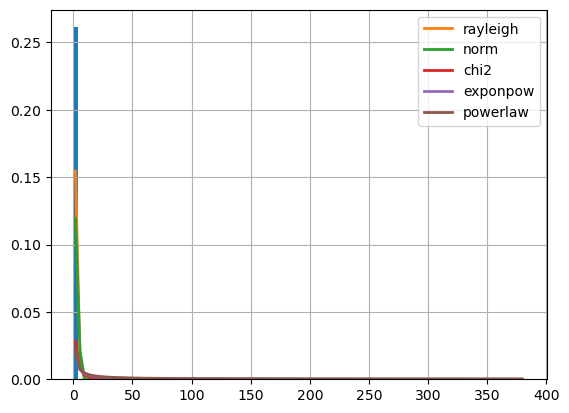

In [32]:
df['fecha_completa'] = pd.to_datetime(df['fecha_completa'])

def obtener_intervalos(df_dir):
    """Calcula lista de intervalos (min) entre registros consecutivos
       asumiendo df_dir ya filtrado por sentido (IN / OUT) y ordenado."""
    tiempos = df_dir['fecha_completa'].sort_values().values
    diffs = np.diff(tiempos).astype('timedelta64[s]').astype(int) / 60.0
    return diffs[diffs > 0]

intervalos_IN  = obtener_intervalos(df[df['TIPO_ACCESO'] == 'IN'])
intervalos_OUT = obtener_intervalos(df[df['TIPO_ACCESO'] == 'OUT'])

print(f"Intervalos IN:  {len(intervalos_IN)} muestras")
print(f"Intervalos OUT: {len(intervalos_OUT)} muestras")

distribuciones = get_common_distributions()

f_in = Fitter(intervalos_IN, distributions=distribuciones, timeout=600)
f_in.fit()
f_in.summary()
best_IN = f_in.get_best(method='sumsquare_error')
print("\nMejor distribución IN:", best_IN)

f_out = Fitter(intervalos_OUT, distributions=distribuciones, timeout=600)
f_out.fit()
f_out.summary()
best_OUT = f_out.get_best(method='sumsquare_error')
print("\nMejor distribución OUT:", best_OUT)



Con este análisis podemos determinar que la distribución que mejor se ajusta a la entrada y salida de talanqueras es rayleigh

In [35]:
from scipy.stats import rayleigh

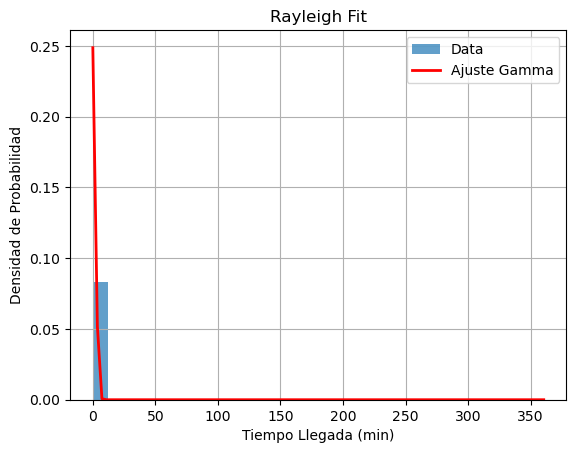

In [36]:
IN_dist = {'loc': -2.2545252044708213, 'scale': 2.428536577723718}

OUT_dist = {'loc': -2.672382308384359, 'scale': 2.862917642285123}

# tiempo llegada siguen una distribución gamma
plt.hist(intervalos_IN, bins=30, density=True, alpha=0.7, label="Data")

# Funcion de densidad de probabilidad para gamma
x = np.linspace(min(intervalos_IN), max(intervalos_IN), 100)
pdf = rayleigh.pdf(x,loc=IN_dist["loc"], scale=IN_dist["scale"])
plt.plot(x, pdf, label="Ajuste Gamma", color="red", linewidth=2)

plt.xlabel("Tiempo Llegada (min)")
plt.ylabel("Densidad de Probabilidad")
plt.title("Rayleigh Fit")
plt.legend()
plt.grid()

# Show the graph
plt.show()